<a href="https://colab.research.google.com/github/iportilla/LLM-101/blob/main/langgraph_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr

!pip install -U langgraph langsmith langchain_anthropic langchain_openai

In [ ]:
import getpass
import os
from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [ ]:
llm = ChatOpenAI(model="o3-mini")

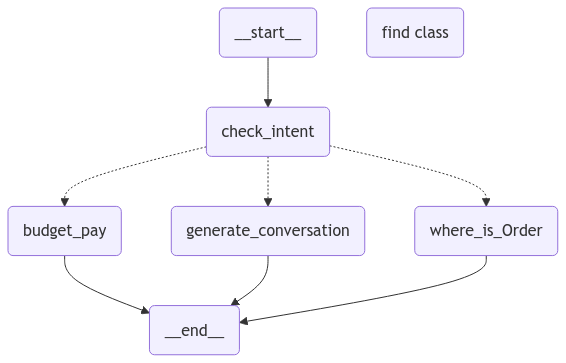

In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    intent: str
    result: int



# Nodes

def check_intent(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    msg = llm.invoke(f"Check the intent of conversation in one word only,Intent can be ['tracking','conversation','Budget pay']  {state['topic']}")
    return {"conversation": msg.content}


def check_intent_class(state: State):
    """Gate function to check if the joke has a punchline"""
    # print(state)
    # Simple check - does the joke contain "?" or "!"
    if "tracking" in state["conversation"].lower():
        return "where_is_Order"
    elif "conversation" in state['conversation'].lower():
      return "generate_conversation"
    elif "budget pay" in state['conversation'].lower():
      return "budget_pay"
    else:
      return "generate_conversation"


def generate_conversation(state: State):
    msg = llm.invoke(f"Start an conversation on  {state['topic']}")
    return {"intent": msg.content,"result":0}


def where_is_Order(state: State):
    return {"intent":"order tracking","result":2+2}

def budget_pay(state: State):
    return {"intent":"budget pay","intent":2-34}




# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("check_intent", check_intent)
workflow.add_node("find class", check_intent_class)
workflow.add_node("generate_conversation", generate_conversation)
workflow.add_node("where_is_Order",where_is_Order)
workflow.add_node("budget_pay",budget_pay)

# Add edges to connect nodes
workflow.add_edge(START, "check_intent")
workflow.add_conditional_edges(
    "check_intent", check_intent_class, {"where_is_Order": "where_is_Order", "generate_conversation": "generate_conversation","budget_pay":"budget_pay"}
)
workflow.add_edge("where_is_Order",END)
workflow.add_edge("generate_conversation",END)
workflow.add_edge('budget_pay',END)
# workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [ ]:
# Invoke
state = chain.invoke({"topic": "waiting for my parcel"})
state

{'topic': 'waiting for my parcel', 'intent': 'order tracking', 'result': 4}

In [ ]:
chain.invoke({"topic": "how many EMI are left"})

{'topic': 'how many EMI are left', 'intent': 'order tracking', 'result': 4}

In [ ]:
chain.invoke({"topic": "my order no. is kdnvkjern"})

{'topic': 'my order no. is kdnvkjern', 'intent': 'order tracking', 'result': 4}

In [ ]:
chain.invoke({"topic": "hi i am looking for a tanzanite ring"})

{'topic': 'hi i am looking for a tanzanite ring',
 'intent': 'Hi there! It’s great to hear you’re looking for a tanzanite ring. They can be absolutely stunning! Do you have any specific styles in mind, or are you just starting to explore your options?',
 'result': 0}

In [ ]:
chain.invoke({"topic": "hi i am looking for a tanzanite ring, what is the price"})

{'topic': 'hi i am looking for a tanzanite ring, what is the price',
 'intent': -32}